<a href="https://colab.research.google.com/github/tylaar1/Quantum-GANs/blob/main/BaseModel_Quantum_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports + Preamble

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from scipy.linalg import sqrtm

Set the random seed for reproducibility

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 1) Data Loading + Pre-Processing

a) Create class that does the loading and pre-processing of the MNIST data

b) create class instance to load in the MNIST data

## 1a) Create class that does the loading and pre-processing of the MNIST data

- `__init__`: stores MNIST filepath, data transformation and filtered MNIST dataframe
- `filter_by_label`: filters for images with the label = [insert [0,9] label]
- `__len__`: returns total number of images in the filtered dataset
- `__getitem__`: retrieves specific image and its label from the dataset based on the provided index. It normalises pixel values, reshapes the image, applies any specified transformations & returns the processed image and label

In [3]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, filepath, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            label (int [0,9], optional): Filter for MNIST images with said specified label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            """
        self.filepath = filepath
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.filepath)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

## 1b) create class instance to load in the MNIST data
This data is filtered by the label kwarg in the DigitDataset class

In [4]:
transform_to_pytorch_tensor = transforms.Compose([transforms.ToTensor()])

dataset = DigitsDataset(
    filepath = "MNIST_images.tra",
    transform = transform_to_pytorch_tensor
)

see what's in our class instance

In [5]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.6250, 1.0000, 0.3750, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4375, 1.0000, 0.5000, 1.0000, 0.3125, 0.0000, 0.0000],
          [0.0000, 0.6875, 1.0000, 0.0000, 0.3750, 0.8750, 0.1875, 0.0000],
          [0.0000, 0.7500, 0.7500, 0.0000, 0.0000, 0.6875, 0.6875, 0.0000],
          [0.0000, 0.7500, 0.7500, 0.0000, 0.0000, 0.5000, 0.7500, 0.0000],
          [0.0000, 0.4375, 0.9375, 0.0625, 0.0000, 0.8125, 0.6875, 0.0000],
          [0.0000, 0.0000, 1.0000, 0.5000, 0.6250, 0.9375, 0.1875, 0.0000],
          [0.0000, 0.0000, 0.6250, 1.0000, 0.9375, 0.1875, 0.0000, 0.0000]]]),
 0)

in the above output we can see the feature map and the label

display the first 8 images in the dataset class instance

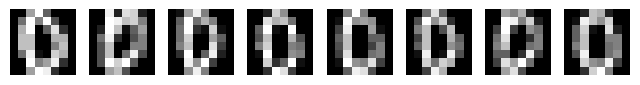

In [6]:
IMAGE_SIZE= 8
reshaped_image_shape = (IMAGE_SIZE, IMAGE_SIZE)

plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(reshaped_image_shape)
    plt.subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

to change the digits printed, change the label kwarg in the DigitDataset class

# 2) Model Building

a) Build class for the classical discriminator

b) Building the quantum generator
- i) define the quantum variables
- ii) define the quantum device
- iii) define the qunatum circuit
- iv) define the partial measurement process
- v) create quantum generator class to use during training

## 2a) Build class for the classical discriminator

- fully connected NN with two hidden layers
- sigmoid output => probability of an input being classified as real

In [7]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__() # calls the constructer of the parent class (nn.Module)

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(IMAGE_SIZE * IMAGE_SIZE, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## 2b) building the quantum generator

Quantum generator consists of `n_generators` sub-generators, each comprised of `n_qubits` qubits

Sub-generator circuit architecture:

<img src="https://pennylane.ai/_images/qcircuit.jpeg" width="500">

---

i) **state embedding**: a latent vector, $z \in \mathbb{R}^N$, is sampled from a uniform distn in the interval $[0, \pi/2)$ and sent to all sub-generators

$z$ --> $|z\rangle$ (state embedding) by applying the RY gates. Each element of z determines the rotation angle of the RY gate.

---

ii) **parameterised layers**: a set of parameterised RY gates apply LINEAR (because they're unitary) TRANSFORMATIONS to the quantum state, followed by control Z gates (to introduce entanglement). This layer is repeated `q_depth` times.

---

iii) **Non-linear transform**: For non-simple generative tasks we need a non-linearity.

Ancillary qubits and partial measurements are used to introduce NON-LINEARITY.

Partial measurement: measure ONLY the ancillary qubits. This collapses them into classical values. We don't care about those values though so just discard them.

The act of measuring the ancillary qubits and collapsing them to classical values forces a non-linear transformation on the remaining qubits. We then measure these remaining qubits to obtain sub-generator output $\boldsymbol{g^{(i)}}$, the output for a given patch of pixels. Normalisation, causes the sum of all its elements to sum to 1

---

iv) **post processing**: all the elements summing to one makes it difficult to map them to pixel intensities

$\tilde{x}(i) = \frac{g(i)}{\max_k g(i)_k}$

this solves the issue by scaling it so the largest values becomes 1 and all other values scale proportionally

---

### 2b) i) define quantum variables - as per the diagram in the above markdown

potentially add grid search for these hyperparams

In [8]:
n_qubits = 5
n_a_qubits = 1
q_depth = 6
n_generators = 4

### 2b) ii) define the quantum device

In [9]:
dev = qml.device("lightning.qubit", wires=n_qubits)

# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2b) iii) define the quantum circuit - loops through different differentiation methods

In [10]:
def circuit_loop(method):  
    @qml.qnode(dev, diff_method=method) # recall the parameter shift differentiation method from lectures, differentiation needed for backprop
    def quantum_circuit(noise, weights):

        weights = weights.reshape(q_depth, n_qubits)

        # State embedding
        for i in range(n_qubits):
            qml.RY(noise[i], wires=i)

        # Repeated layer
        for i in range(q_depth):
            # Parameterised layer
            for y in range(n_qubits):
                qml.RY(weights[i][y], wires=y)

            # Control Z gates
            for y in range(n_qubits - 1):
                qml.CZ(wires=[y, y + 1])

        return qml.probs(wires=list(range(n_qubits)))
    return quantum_circuit

# diff_methods = ["spsa", "parameter-shift", "finite-diff"]
# quantum_circuits = [circuit_loop(method) for method in diff_methods]
# quantum_circuits

### 2b) iv) define the partial measurement process

In [11]:
def partial_measure(noise, weights):
    # Non-linear Transform
    diff_methods = ["spsa", "parameter-shift", "finite-diff"] 
    probs = []
    for method in diff_methods:
        quantum_circuit = circuit_loop(method)

        circuit_probs = quantum_circuit(noise, weights)

        probsgiven0 = circuit_probs[: (2 ** (n_qubits - n_a_qubits))]
        probsgiven0 /= torch.sum(circuit_probs)
        
        # Post-Processing
        probsgiven = probsgiven0 / torch.max(probsgiven0)
        probs.append(probsgiven)

    return probs

### 2b) v) create a quantum generator class to use during training

- `__init__`: initialises the quantum generator, holds container for the learnable weights that will updated during training (`self.q_params`)
- `forward`: iterates over `self.q_params` list which contains the paramters for each sub-generator used to generate the output patches, the patches are concatenated together to form a full image

In [12]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, quantum_circuit):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            quantum_circuit (callable): Quantum circuit (QNode) to be used by the generator.
        """
        super().__init__()
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(torch.rand(q_depth * n_qubits, device=device), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators
        self.quantum_circuit = quantum_circuit

    def forward(self, input_batch):
        # List to store the generated images
        images = []

        # Iterate over all sub-generators
        for params in self.q_params:
            # List to store patches for the current sub-generator
            patches = []

            # Iterate over each element in the input batch
            for elem in input_batch:
                elem = elem.to(device)  # Move the input batch to the GPU

                # Call the quantum circuit with the first differentiation method's output
                q_out = self.quantum_circuit(elem, params).float().unsqueeze(0)
                patches.append(q_out)

            # Concatenate patches for the current sub-generator
            patches = torch.cat(patches, dim=0)  # Shape: (batch_size, PATCH_SIZE)
            images.append(patches)

        # Concatenate all sub-generator outputs to form the final images
        images = torch.cat(images, dim=1)  # Shape: (batch_size, total_image_size)
        images = images.view(-1,64)
        return images

# 3) Training + Evaluation

a) define learning rates and number of training iterations

b) define quantum eval metric

c) create dataloader object

d) execute training process

e) plot generated images at training iteration intervals

## 3a) define learning rates and number of training iterations

In [13]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

## 3b) define quantitative eval metric (FID)

In [14]:
def calculate_fid(act1, act2):
    """Calculate the FID score between two sets of activations.

    This function has been modified to handle potential shape mismatches
    between the real and generated images. It now ensures that both sets
    of activations have the same number of features before calculating
    the FID score.

    Args:
        act1 (np.ndarray): Activations of real images.
        act2 (np.ndarray): Activations of generated images.

    Returns:
        float: FID score.
    """
    # Ensure both sets of activations have the same number of features
    num_features = min(act1.shape[1], act2.shape[1])
    act1 = act1[:, :num_features]
    act2 = act2[:, :num_features]

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

## 3c) create data loader object

dataloaders efficiently load date in batches during training

In [19]:
BATCH_SIZE = 32

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

## 3d) Execute training process

In [18]:
# generator = PatchQuantumGenerator(n_generators).to(device)
# noise = torch.rand(BATCH_SIZE, n_qubits, device=device) * math.pi / 2
# fake_data = generator(noise)

# # diff_methods = ["spsa", "parameter-shift", "finite-diff"]


Training GAN with differentiation method: spsa

Epoch 1/10
Batch 0/11 - Discriminator Loss: 1.3852, Generator Loss: 0.8244, FID Score: 29.927
Batch 10/11 - Discriminator Loss: 1.3095, Generator Loss: 0.8325, FID Score: 28.408
Epoch 1/10 - FID Score: 28.408

Epoch 2/10
Batch 0/11 - Discriminator Loss: 1.3008, Generator Loss: 0.8341, FID Score: 27.792
Batch 10/11 - Discriminator Loss: 1.2166, Generator Loss: 0.8584, FID Score: 30.061
Epoch 2/10 - FID Score: 30.061

Epoch 3/10
Batch 0/11 - Discriminator Loss: 1.2071, Generator Loss: 0.8628, FID Score: 28.492
Batch 10/11 - Discriminator Loss: 1.0772, Generator Loss: 0.9051, FID Score: 26.904
Epoch 3/10 - FID Score: 26.904

Epoch 4/10
Batch 0/11 - Discriminator Loss: 1.0521, Generator Loss: 0.9126, FID Score: 28.701
Batch 10/11 - Discriminator Loss: 0.8909, Generator Loss: 0.9810, FID Score: 30.406
Epoch 4/10 - FID Score: 30.406

Epoch 5/10
Batch 0/11 - Discriminator Loss: 0.8686, Generator Loss: 0.9930, FID Score: 28.384
Batch 10/11 - Dis

/home/apyba3/anaconda3/envs/quantprojenv/lib/python3.10/site-packages/pennylane/gradients/finite_difference.py:384: UserWarning: Finite differences with float32 detected. Answers may be inaccurate. float64 is recommended.
  warn(


Batch 0/11 - Discriminator Loss: 1.4136, Generator Loss: 0.7837, FID Score: 26.761
Batch 10/11 - Discriminator Loss: 1.3168, Generator Loss: 0.7794, FID Score: 28.205
Epoch 1/10 - FID Score: 28.205

Epoch 2/10
Batch 0/11 - Discriminator Loss: 1.3036, Generator Loss: 0.7793, FID Score: 28.027
Batch 10/11 - Discriminator Loss: 1.1491, Generator Loss: 0.7856, FID Score: 28.557
Epoch 2/10 - FID Score: 28.557

Epoch 3/10
Batch 0/11 - Discriminator Loss: 1.1371, Generator Loss: 0.7870, FID Score: 27.921
Batch 10/11 - Discriminator Loss: 0.9437, Generator Loss: 0.8047, FID Score: 29.954
Epoch 3/10 - FID Score: 29.954

Epoch 4/10
Batch 0/11 - Discriminator Loss: 0.9287, Generator Loss: 0.8089, FID Score: 28.102
Batch 10/11 - Discriminator Loss: 0.7234, Generator Loss: 0.8513, FID Score: 25.923
Epoch 4/10 - FID Score: 25.923

Epoch 5/10
Batch 0/11 - Discriminator Loss: 0.7199, Generator Loss: 0.8568, FID Score: 27.313
Batch 10/11 - Discriminator Loss: 0.5853, Generator Loss: 0.9294, FID Score: 

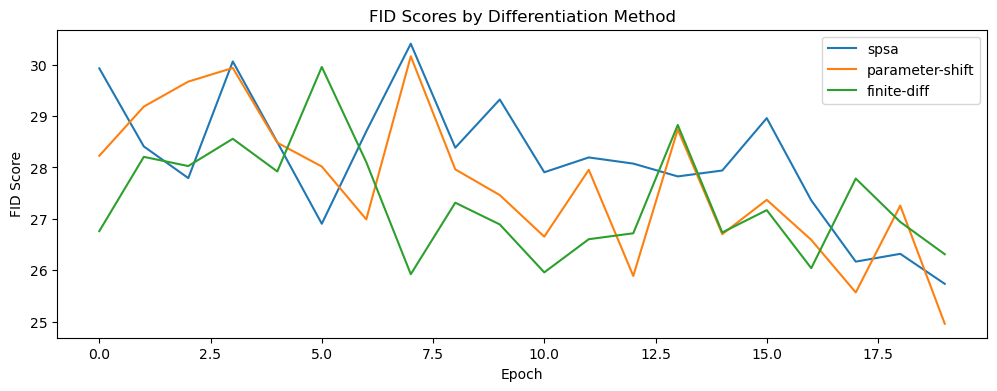

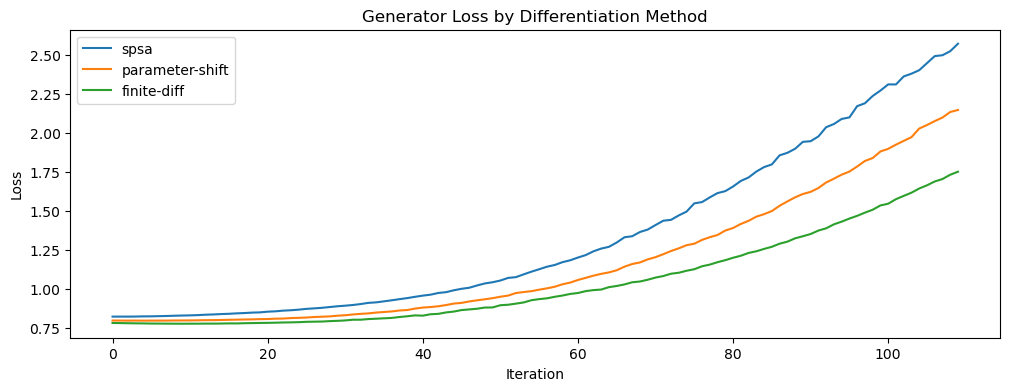

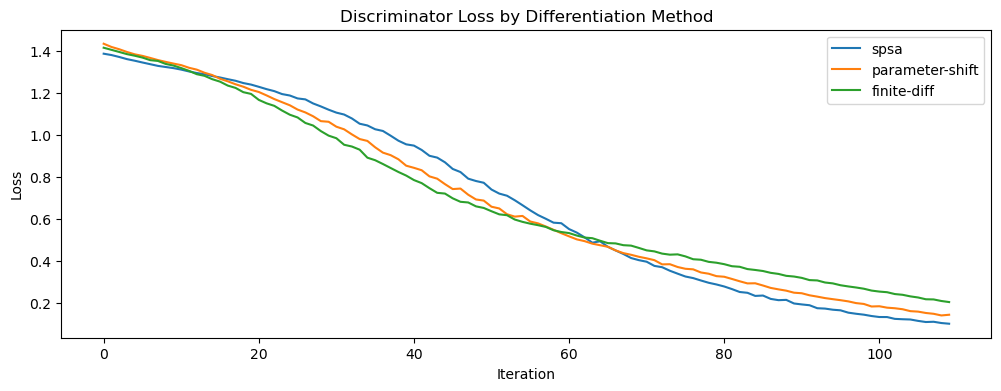

In [20]:
## 3d) Execute training process

# Differentiation methods to compare
diff_methods = ["spsa", "parameter-shift", "finite-diff"]

# Store results for each method
results_by_method = []

# Training parameters
num_epochs = 10  # Number of epochs
# BATCH_SIZE = 64  # Batch size
lrG = 0.001      # Learning rate for generator
lrD = 0.001      # Learning rate for discriminator

# Fixed noise for visualization
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Binary cross-entropy loss
criterion = nn.BCELoss()

for method in diff_methods:
    print(f"\nTraining GAN with differentiation method: {method}")

    # Create the quantum circuit for the current differentiation method
    quantum_circuit = circuit_loop(method)

    # Initialize the generator and discriminator
    generator = PatchQuantumGenerator(n_generators, quantum_circuit).to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optG = optim.Adam(generator.parameters(), lr=lrG)
    optD = optim.Adam(discriminator.parameters(), lr=lrD)

    # Metrics storage
    fid_scores = []
    gen_losses = []
    disc_losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for batch_idx, (real_data, _) in enumerate(dataloader):
            # Move real data to device
            real_data = real_data.view(-1, IMAGE_SIZE * IMAGE_SIZE).to(device)

            # Generate fake data
            noise = torch.rand(BATCH_SIZE, n_qubits, device=device) * math.pi / 2
            fake_data = generator(noise)

            # Train discriminator
            discriminator.zero_grad()
            outD_real = discriminator(real_data).view(-1)
            outD_fake = discriminator(fake_data.detach()).view(-1)

            # Dynamically match the size of labels to the discriminator's output
            real_labels = torch.full(outD_real.size(), 1.0, dtype=torch.float, device=device)
            fake_labels = torch.full(outD_fake.size(), 0.0, dtype=torch.float, device=device)

            # Calculate discriminator loss
            errD_real = criterion(outD_real, real_labels)
            errD_fake = criterion(outD_fake, fake_labels)
            errD = errD_real + errD_fake
            errD.backward()
            optD.step()

            # Train generator
            generator.zero_grad()
            outD_fake = discriminator(fake_data).view(-1)
            real_labels = torch.full(outD_fake.size(), 1.0, dtype=torch.float, device=device)  # Match size dynamically
            errG = criterion(outD_fake, real_labels)  # Generator tries to fool the discriminator
            errG.backward()
            optG.step()

            # Track losses
            gen_losses.append(errG.item())
            disc_losses.append(errD.item())

            # Print progress for the current batch
            if batch_idx % 10 == 0:  # Print every 10 batches
                # Calculate FID score for the current batch
                with torch.no_grad():
                    test_images = generator(fixed_noise).view(8, -1).cpu().detach().numpy()
                    real_batch, _ = next(iter(dataloader))
                    real_batch = real_batch.view(8, -1).numpy()
                    fid_score = calculate_fid(real_batch, test_images)
                    fid_scores.append(fid_score)

                print(f"Batch {batch_idx}/{len(dataloader)} - "
                      f"Discriminator Loss: {errD.item():.4f}, Generator Loss: {errG.item():.4f}, "
                      f"FID Score: {fid_score:.3f}")

        # Print FID score for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs} - FID Score: {fid_score:.3f}")

    # Store results for this method
    results_by_method.append({
        "method": method,
        "fid_scores": fid_scores,
        "gen_losses": gen_losses,
        "disc_losses": disc_losses
    })

# Plot the results
import matplotlib.pyplot as plt

# Plot FID scores
plt.figure(figsize=(12, 4))
for result in results_by_method:
    plt.plot(result["fid_scores"], label=result["method"])
plt.title("FID Scores by Differentiation Method")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# Plot generator losses
plt.figure(figsize=(12, 4))
for result in results_by_method:
    plt.plot(result["gen_losses"], label=result["method"])
plt.title("Generator Loss by Differentiation Method")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot discriminator losses
plt.figure(figsize=(12, 4))
for result in results_by_method:
    plt.plot(result["disc_losses"], label=result["method"])
plt.title("Discriminator Loss by Differentiation Method")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# retrying above cell

In [ ]:
## 3d) Execute training process

# Differentiation methods to compare
diff_methods = ["spsa", "parameter-shift", "finite-diff"]

# Store results for each method
results_by_method = []

# Training parameters
num_epochs = 100  # Number of epochs
# BATCH_SIZE = 64  # Batch size
lrG = 0.001      # Learning rate for generator
lrD = 0.001      # Learning rate for discriminator

# Fixed noise for visualization and consistent FID calculation
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Get a fixed real batch for consistent FID calculation
fixed_real_batch, _ = next(iter(dataloader))
fixed_real_batch = fixed_real_batch.view(fixed_real_batch.size(0), -1).cpu().numpy()

# Binary cross-entropy loss
criterion = nn.BCELoss()

for method in diff_methods:
    print(f"\nTraining GAN with differentiation method: {method}")

    # Create the quantum circuit for the current differentiation method
    quantum_circuit = circuit_loop(method)

    # Initialize the generator and discriminator
    generator = PatchQuantumGenerator(n_generators, quantum_circuit).to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optG = optim.Adam(generator.parameters(), lr=lrG)
    optD = optim.Adam(discriminator.parameters(), lr=lrD)

    # Metrics storage - only for epoch-level tracking
    epoch_fid_scores = []
    epoch_gen_losses = []
    epoch_disc_losses = []

    for epoch in range(num_epochs):
        # Reset accumulators for this epoch
        running_gen_loss = 0.0
        running_disc_loss = 0.0
        batch_count = 0
        
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for batch_idx, (real_data, _) in enumerate(dataloader):
            # Move real data to device
            real_data = real_data.view(-1, IMAGE_SIZE * IMAGE_SIZE).to(device)

            # Generate fake data
            noise = torch.rand(BATCH_SIZE, n_qubits, device=device) * math.pi / 2
            fake_data = generator(noise)

            # Train discriminator
            discriminator.zero_grad()
            outD_real = discriminator(real_data).view(-1)
            outD_fake = discriminator(fake_data.detach()).view(-1)

            # Dynamically match the size of labels to the discriminator's output
            real_labels = torch.full(outD_real.size(), 1.0, dtype=torch.float, device=device)
            fake_labels = torch.full(outD_fake.size(), 0.0, dtype=torch.float, device=device)

            # Calculate discriminator loss
            errD_real = criterion(outD_real, real_labels)
            errD_fake = criterion(outD_fake, fake_labels)
            errD = errD_real + errD_fake
            errD.backward()
            optD.step()

            # Train generator
            generator.zero_grad()
            outD_fake = discriminator(fake_data).view(-1)
            real_labels = torch.full(outD_fake.size(), 1.0, dtype=torch.float, device=device)
            errG = criterion(outD_fake, real_labels)  # Generator tries to fool the discriminator
            errG.backward()
            optG.step()

            # Accumulate losses for epoch average (not storing individual batch losses)
            running_gen_loss += errG.item()
            running_disc_loss += errD.item()
            batch_count += 1

            # # Print progress for the current batch (only for monitoring, not storing)
            # if batch_idx % 1 == 0:  # Print every 10 batches
            #     print(f"Batch {batch_idx}/{len(dataloader)}")

        # Calculate epoch-level metrics
        avg_gen_loss = running_gen_loss / batch_count
        avg_disc_loss = running_disc_loss / batch_count
        
        # Calculate FID score once per epoch
        with torch.no_grad():
            test_images = generator(fixed_noise).view(fixed_noise.size(0), -1).cpu().detach().numpy()
            fid_score = calculate_fid(fixed_real_batch, test_images)
        
        # Store epoch-level metrics only
        epoch_gen_losses.append(avg_gen_loss)
        epoch_disc_losses.append(avg_disc_loss)
        epoch_fid_scores.append(fid_score)

        # Print epoch-level metrics
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Avg Generator Loss: {avg_gen_loss:.4f}, "
              f"Avg Discriminator Loss: {avg_disc_loss:.4f}, "
              f"FID Score: {fid_score:.3f}")

    # Store results for this method (epoch-level metrics only)
    results_by_method.append({
        "method": method,
        "fid_scores": epoch_fid_scores,
        "gen_losses": epoch_gen_losses,
        "disc_losses": epoch_disc_losses
    })

# Plot the results - all metrics per epoch
import matplotlib.pyplot as plt

# Plot FID scores
plt.figure(figsize=(12, 4))
for result in results_by_method:
    plt.plot(range(1, num_epochs+1), result["fid_scores"], label=result["method"], marker='o')
plt.title("FID Scores by Differentiation Method")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.grid(True)
plt.show()

# Plot generator losses
plt.figure(figsize=(12, 4))
for result in results_by_method:
    plt.plot(range(1, num_epochs+1), result["gen_losses"], label=result["method"], marker='o')
plt.title("Generator Loss by Differentiation Method")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot discriminator losses
plt.figure(figsize=(12, 4))
for result in results_by_method:
    plt.plot(range(1, num_epochs+1), result["disc_losses"], label=result["method"], marker='o')
plt.title("Discriminator Loss by Differentiation Method")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.show()


Training GAN with differentiation method: spsa

Epoch 1/100


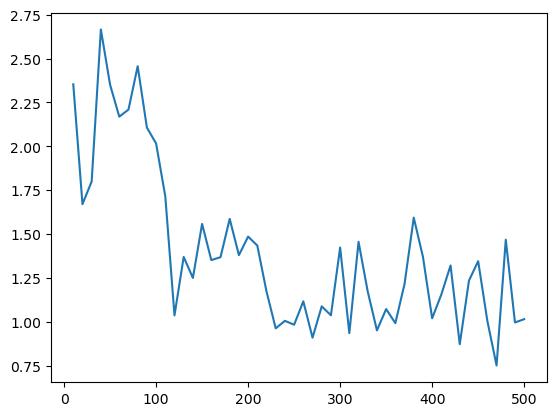

In [ ]:
plt.plot(np.arange(10,len(fid_scores)*10+1,10), fid_scores)

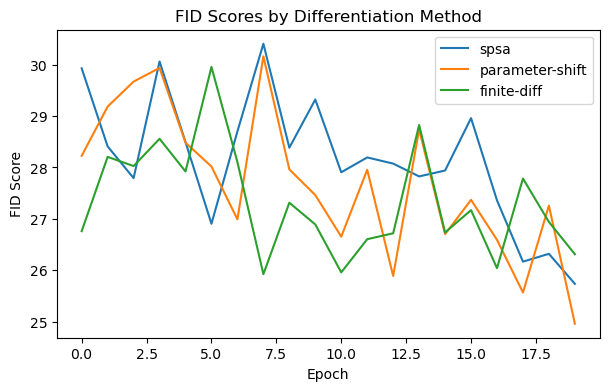

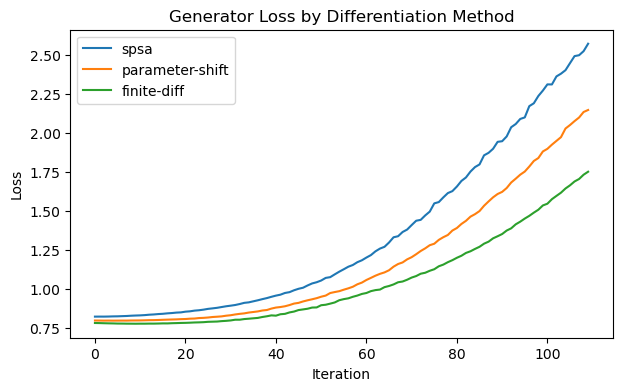

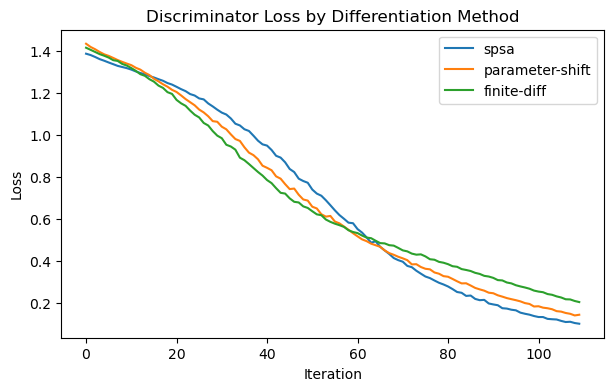

In [23]:
# Plot FID scores
plt.figure(figsize=(7, 4))
for result in results_by_method:
    plt.plot(result["fid_scores"], label=result["method"])
plt.title("FID Scores by Differentiation Method")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# Plot generator losses
plt.figure(figsize=(7, 4))
for result in results_by_method:
    plt.plot(result["gen_losses"], label=result["method"])
plt.title("Generator Loss by Differentiation Method")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot discriminator losses
plt.figure(figsize=(7, 4))
for result in results_by_method:
    plt.plot(result["disc_losses"], label=result["method"])
plt.title("Discriminator Loss by Differentiation Method")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [26]:
len(result["fid_scores"])

20

## 3e) plot how the generated imgaes evolved throughout training

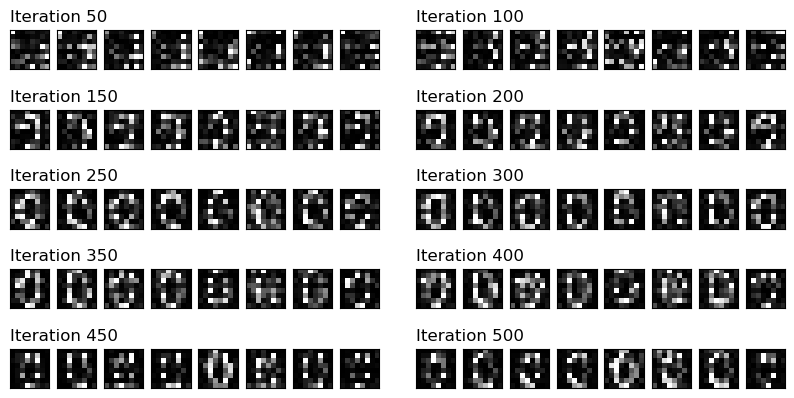

In [ ]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()